## Import Tensorflow Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Create our Training Dataset and Validation Dataset

In [40]:
data_dir = "nvme_drive/Training Data"
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 64
img_height = 180
img_width = 180
train_ds = train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="training",
  seed=12345689,
  image_size=(img_height, img_width),
  batch_size=batch_size)




val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.15,
  subset="validation",
  seed=12345689,
  image_size=(img_height, img_width),
  batch_size=batch_size)


class_names = train_ds.class_names
print(class_names)

Found 673148 files belonging to 4 classes.
Using 572176 files for training.
Found 673148 files belonging to 4 classes.
Using 100972 files for validation.
['Gore', 'None', 'Pornographic', 'Racy']


## Create Model

### Resize and Rescale all Datasets

In [41]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])


val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

#Data augmentation should only be applied to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

#Buffered prefetching applied to all datasets
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

#### Dropout regularization of the Network

In [42]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build()
model.summary()


Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_22 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)      

## Train the Model

In [44]:
epochs=12
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/12
8941/8941 [==============================] - 236s 26ms/step - loss: 0.8170 - accuracy: 0.6568 - val_loss: 0.8152 - val_accuracy: 0.6589
Epoch 2/12
8941/8941 [==============================] - 236s 26ms/step - loss: 0.8170 - accuracy: 0.6568 - val_loss: 0.8151 - val_accuracy: 0.6589
Epoch 3/12
8941/8941 [==============================] - 236s 26ms/step - loss: 0.8170 - accuracy: 0.6568 - val_loss: 0.8151 - val_accuracy: 0.6589
Epoch 4/12
8941/8941 [==============================] - 235s 26ms/step - loss: 0.8170 - accuracy: 0.6568 - val_loss: 0.8152 - val_accuracy: 0.6589
Epoch 5/12
8941/8941 [==============================] - 236s 26ms/step - loss: 0.8170 - accuracy: 0.6568 - val_loss: 0.8151 - val_accuracy: 0.6589
Epoch 6/12
8941/8941 [==============================] - 236s 26ms/step - loss: 0.8170 - accuracy: 0.6568 - val_loss: 0.8151 - val_accuracy: 0.6589
Epoch 7/12
8941/8941 [==============================] - 236s 26ms/step - loss: 0.8170 - accuracy: 0.6568 - val_loss: 0

## Get Training Results

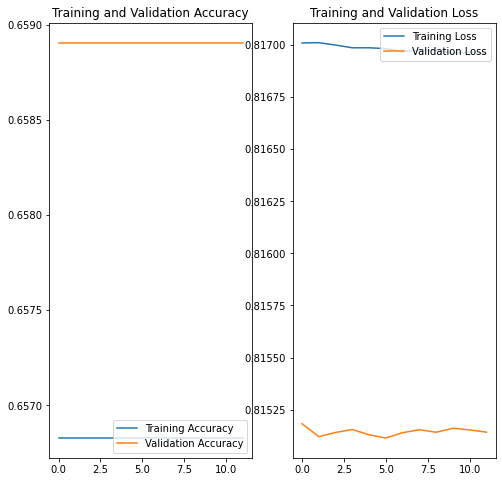

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test Our Model

In [9]:
#Predict on the current dataset
image_path = ""
img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

FileNotFoundError: [Errno 2] No such file or directory: ''

## Save our Dataset

In [8]:
import time

timestr = time.strftime("%Y%m%d-%H%M%S")
model.save("nvme_drive/Trained Models/" + timestr + "-SafetyNet")